# Import librairies

In [1]:
# Librairies for basics manipulation on file
import os
import sys
import inspect
from os import listdir
from os.path import isfile, join
import inspect
import six

# Math and array and data manipulation librairies
import math
import numpy as np
import pandas as pd
from random import sample
import random

# Images librairies
import cv2
from easyimages import EasyImageList

# Plots librairies
from matplotlib import pyplot as plt

# plt.rcParams["figure.figsize"] = (10,10)
import seaborn as sns
import plotly.graph_objects as go
from scipy.interpolate import griddata
import plotly.offline as pyo
import plotly.io as pio

# Add missing modules
sys.modules["sklearn.externals.six"] = six
# ML Librairies
import mlrose

%matplotlib widget

sys.path.insert(0, "/appli")
from utile.plot import plot_sample, plot_img_hist, plot_hist_3D

seed = 53

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Analysis of images

__The aim of this part is to have a small anaylis on the 512*512 PNG images before using them__

## Import csv tabluar data

In [2]:
# Import train data
img_path = "../kaggle_dataset"
train_df = pd.read_csv("data/train.csv")

In [3]:
train_df.head(5)

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [4]:
# Display all views possible (Note that there are only some labels (AT, LM, ML, LMO) are surely equal to MLO or CC)
train_df["view"].value_counts()

MLO    27903
CC     26765
AT        19
LM        10
ML         8
LMO        1
Name: view, dtype: int64

In [5]:
# View laterality
train_df["laterality"].value_counts()

R    27439
L    27267
Name: laterality, dtype: int64

In [6]:
# Create the path of the image in the dataframe
train_df["path"] = train_df.apply(
    lambda x: "".join(
        [img_path, "/", str(x["patient_id"]), "_", str(x["image_id"]), ".png"]
    ),
    axis=1,
)

## Import of images

In [7]:
# Take the n first files names of the dataset of images
n_files = 30
onlyfiles = [f for f in listdir(img_path)[:n_files] if isfile(join(img_path, f))]

In [8]:
# Load the list of images
imgs = []
for file in onlyfiles:
    img = cv2.imread(f"{img_path}/{file}")
    imgs.append(img)
# Print the Shape of image as it is a Numpy Array
print("Image Shape:", img.shape)

Image Shape: (512, 512, 3)


## Quick preview of images

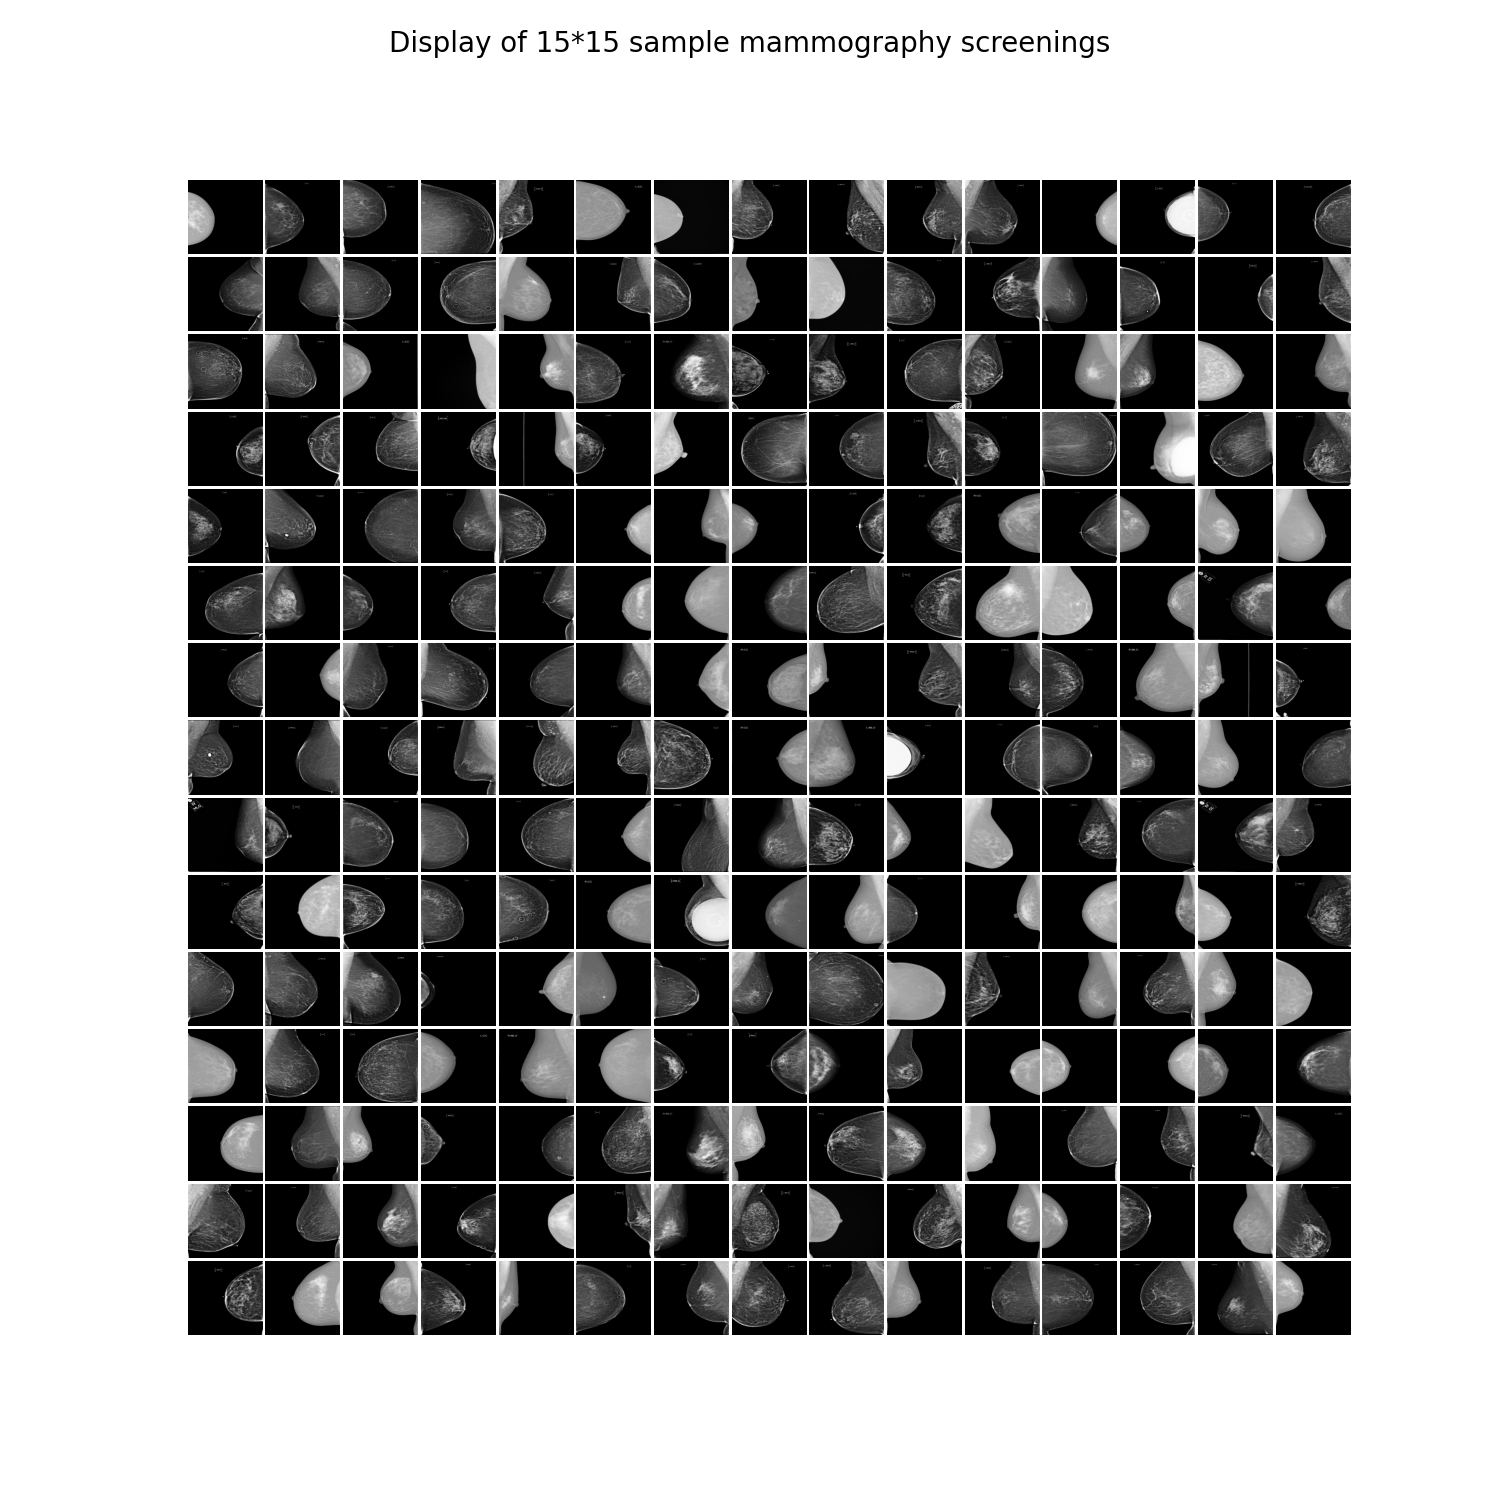

In [9]:
# Number of rows
n = 15
# Number of columns
m = 15
# Plot sample of images
plot_sample(
    files=img_path,
    m=m,
    n=n,
    title=f"Display of {n}*{m} sample mammography screenings",
    seed=53,
)

In [10]:
# Li = EasyImageList.from_folder(path)
# Li.html(sample=800, size=30)

__Here we can see that it seems that the data don't have missing or incoherent images (the sample is not necessary representative from the dataset since we only take 800 images from more than 50k). It appears that images have very different shapes, contrast, luminosity. It is also worth mentioning that black pixels represent on many screenings an important part of the image.There are also some anotations about the view of the image on the image__

## Hard examples

In [11]:
hard_examples_list = [
    "1511_1760744211",
    "25323_1743461841",
    "26530_166085523",
    "38739_1110010839",
    "7412_264916633",
    "1511_764545189",
    "822_1942326353",
    "55724_694341224",
]
hard_examples_list_path = [
    "".join([img_path, "/", x.split("_")[0], "_", x.split("_")[1], ".png"])
    for x in hard_examples_list
]

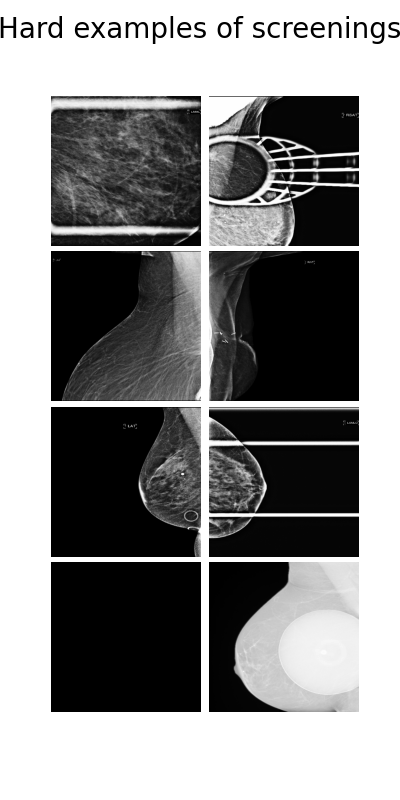

In [12]:
plot_sample(
    files=hard_examples_list_path,
    m=2,
    n=4,
    title="Hard examples of screenings",
    fig_size=(4, 8),
)

__Here are some "hard examples" we can find in the dataset. One could see that there are some artefacts in some images; some images have high saturation, or unusual zooms__

## Display some images with histograms

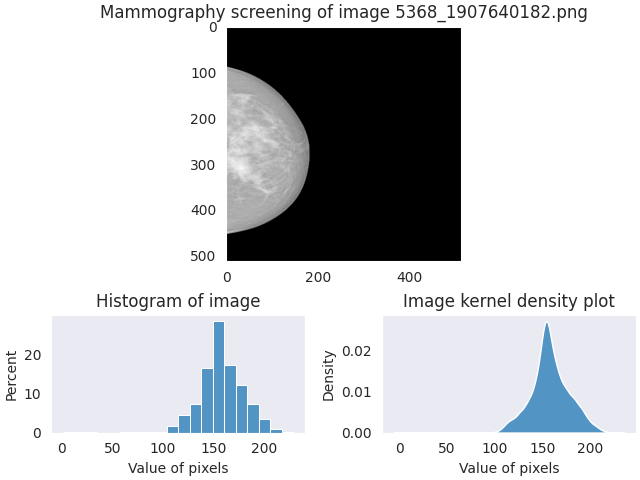

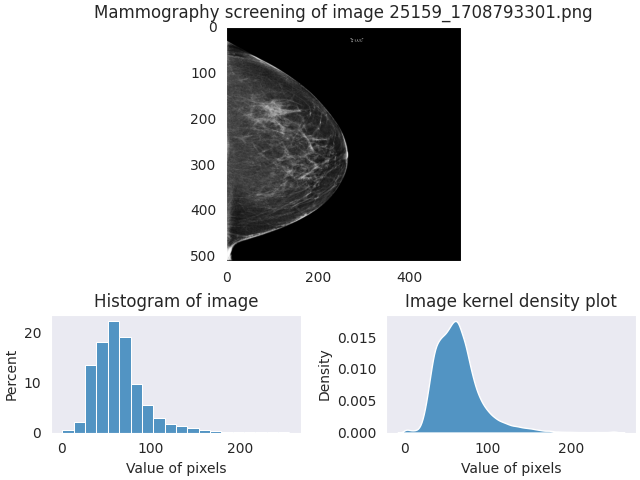

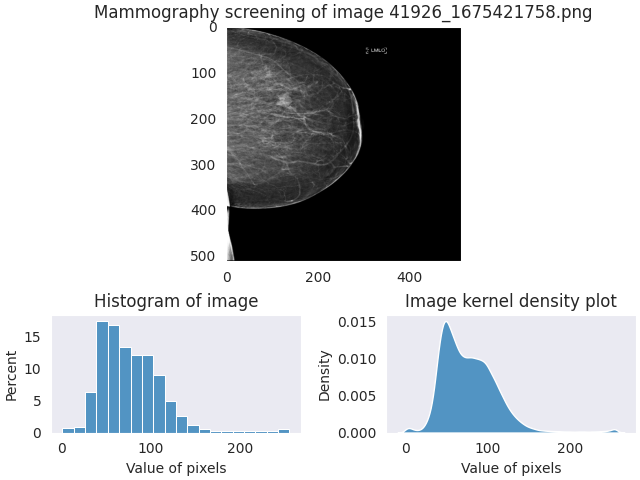

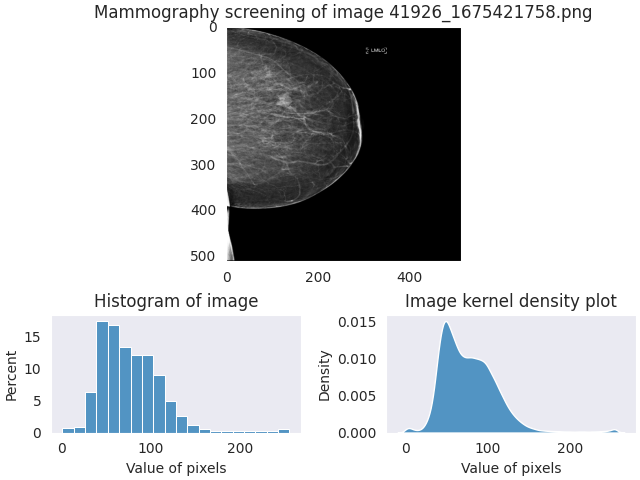

In [13]:
plot_img_hist(
    files=img_path,
    n=3,
    seed=seed,
)

__We could see that images seem to have a large part of pixels that has the value 0 (we remove them from histograms to ease the read) and they seem to have different histograms shape (different range of pixels values, different repartitions and different contrasts...)__

## Normalized images

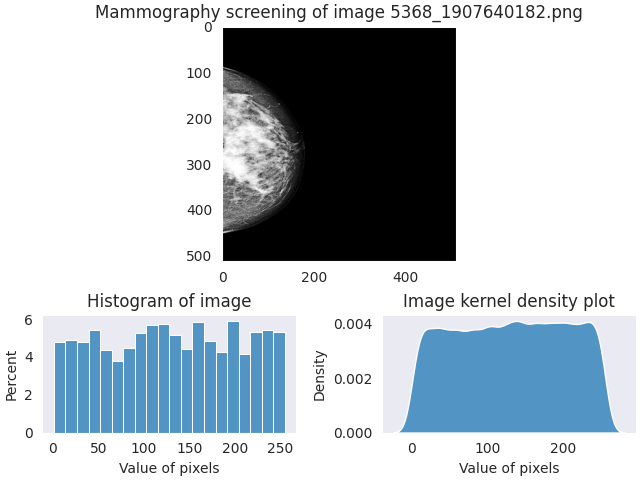

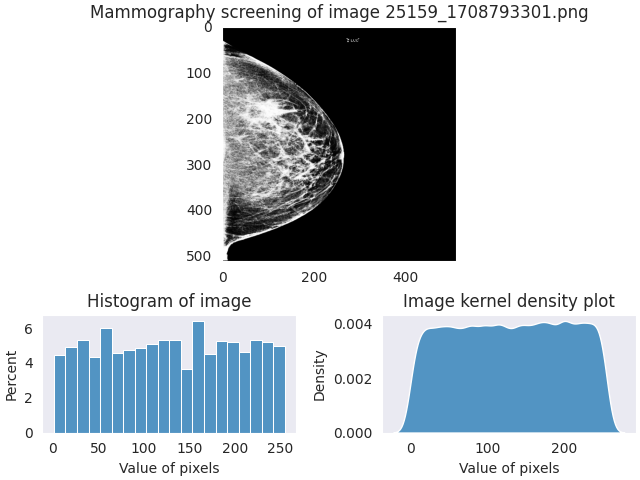

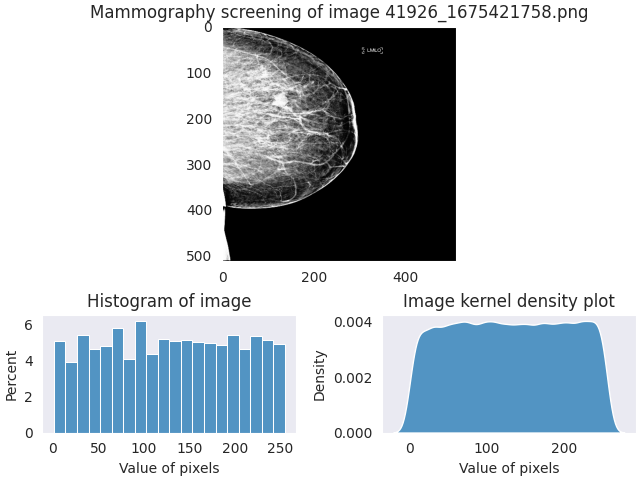

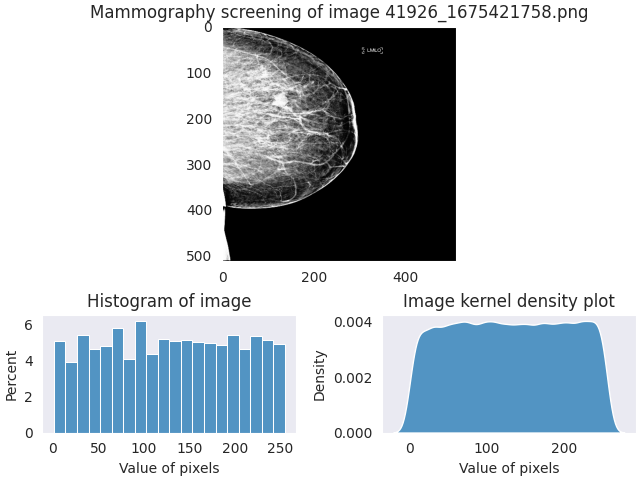

In [14]:
plot_img_hist(files=img_path, n=3, seed=seed, normalize=True)

__After having equalized histograms, we could see that range and contrast in images seem to be more similar between images, it could be intersting to see if it enhances results in models__

## 3D histograms

__This part is too have a deeper view on how different are histograms of images, by using plotting histograms in a 3D space and by interpolating to have a surface, since the placement of images' histograms are arbitrary on the 3D space, one could use an optimization approach so that histograms that are similar are closer on the 3D space (detailed later)__ 

The following cell is not mandatory to run, it computes the distance between histograms of images (with MSE) and then uses a TSP model to smoothen the surface (reduce/avoid high variation between 2 histograms for 2 screenings), be careful, don't use it if there are too many screenings (high complextity for the algorithm)
You can find more details there: https://mlrose.readthedocs.io/en/stable/source/tutorial2.html

In [8]:
# Set notebook mode to work in offline
pyo.init_notebook_mode()

plot_hist_3D(files=img_path, n=10, seed=3, smoothen=True)

Dist shape 0 	 10
Dist shape 1 	 10
best state 	 [6 8 2 3 0 7 5 9 1 4]
10


# Some basics analysis on images

__This part's aim is to have a closer look to the images and to see if pre-processing is needed__

https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

In [ ]:
# Create dataframe for each triplet of laterality, view, and having the cancer or not
L_MLO_C = train_df[
    (train_df["laterality"] == "L")
    & (train_df["view"] == "MLO")
    & (train_df["cancer"] == 1)
]
R_MLO_C = train_df[
    (train_df["laterality"] == "R")
    & (train_df["view"] == "MLO")
    & (train_df["cancer"] == 1)
]
L_CC_C = train_df[
    (train_df["laterality"] == "L")
    & (train_df["view"] == "CC")
    & (train_df["cancer"] == 1)
]
R_CC_C = train_df[
    (train_df["laterality"] == "R")
    & (train_df["view"] == "CC")
    & (train_df["cancer"] == 1)
]

L_MLO_NC = train_df[
    (train_df["laterality"] == "L")
    & (train_df["view"] == "MLO")
    & (train_df["cancer"] == 0)
]
R_MLO_NC = train_df[
    (train_df["laterality"] == "R")
    & (train_df["view"] == "MLO")
    & (train_df["cancer"] == 0)
]
L_CC_NC = train_df[
    (train_df["laterality"] == "L")
    & (train_df["view"] == "CC")
    & (train_df["cancer"] == 0)
]
R_CC_NC = train_df[
    (train_df["laterality"] == "R")
    & (train_df["view"] == "CC")
    & (train_df["cancer"] == 0)
]

# Add the real name of view
LView = [L_MLO_C, R_MLO_C, L_CC_C, R_CC_C, L_MLO_NC, R_MLO_NC, L_CC_NC, R_CC_NC]
LName = [
    "Left Mediolateral Oblique with cancer",
    "Right Mediolateral Oblique with cancer",
    "Left Cranial Caudal with cancer",
    "Right Cranial Caudal with cancer",
    "Left Mediolateral Oblique without cancer",
    "Right Mediolateral Oblique without cancer",
    "Left Cranial Caudal without cancer",
    "Right Cranial Caudal without cancer",
]
NbC = sum([len(elem) for elem in LView[:4]])
NbNC = sum([len(elem) for elem in LView[4:]])
N = [NbC, NbNC]
NText = ["with cancer", "without Cancer"]
compt = 0
# Print the repartition of examples repartition between view,laterality and having cancer or not
for ind, (view, name) in enumerate(zip(LView, LName)):
    compt += 1
    print(
        f" There are {len(view)} images of: {name} ; That represents of {'{:.1%}'.format(len(view)/N[ind//4])} of people {NText[ind//4]} and {'{:.2%}'.format(len(view)/len(train_df))} of all images"
    )
    if compt == 4:
        print()

In each mammogram examination, a breast is typically imaged with two different views, i.e., the mediolateral oblique (MLO) view and cranial caudal (CC) view; cf. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6113143/

__From the statistics above, one could see that each view and laterality is represented quite equally, the main gap being with and without cancer, since cancer is an anomaly__

In [ ]:
# Creat samples dataset for average images
n_samples = 100

L_MLO_C_Sample = L_MLO_C.sample(n=n_samples)
R_MLO_C_Sample = R_MLO_C.sample(n=n_samples)
L_CC_C_Sample = L_CC_C.sample(n=n_samples)
R_CC_C_Sample = R_CC_C.sample(n=n_samples)

L_MLO_NC_Sample = L_MLO_NC.sample(n=n_samples)
R_MLO_NC_Sample = R_MLO_NC.sample(n=n_samples)
L_CC_NC_Sample = L_CC_NC.sample(n=n_samples)
R_CC_NC_Sample = R_CC_NC.sample(n=n_samples)
Sample_list = [
    L_MLO_C_Sample,
    R_MLO_C_Sample,
    L_CC_C_Sample,
    R_CC_C_Sample,
    L_MLO_NC_Sample,
    R_MLO_NC_Sample,
    L_CC_NC_Sample,
    R_CC_NC_Sample,
]

In [ ]:
# Create the average image for each view
mean_images = []
for sample_elem in Sample_list:
    list_for_mean = []
    for file in sample_elem["path"]:
        img = cv2.imread(file)
        img = cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        list_for_mean.append(img)
    list_for_mean = np.array(list_for_mean)
    mean_img = np.mean(list_for_mean, axis=0) / 255
    mean_images.append(mean_img)
mean_images = np.array(mean_images)
LName = [
    "Left Mediolateral Oblique with cancer",
    "Right Mediolateral Oblique with cancer",
    "Left Cranial Caudal with cancer",
    "Right Cranial Caudal with cancer",
    "Left Mediolateral Oblique without cancer",
    "Right Mediolateral Oblique without cancer",
    "Left Cranial Caudal without cancer",
    "Right Cranial Caudal without cancer",
]

In [ ]:
sns.set_style("dark")
fig5 = plt.figure(constrained_layout=True, figsize=(20, 40))
widths = [10, 10]
heights = [40, 40, 40, 40]
spec5 = fig5.add_gridspec(ncols=2, nrows=4, width_ratios=widths, height_ratios=heights)

ax = fig5.add_subplot(spec5[0, 0])
ax.set_title("Average L-LMO screening with cancer")
ax.title.set_size(20)
plt.imshow(mean_images[0], cmap="gray")
ax.annotate(
    "With cancer",
    xy=(0.5, 1),
    xytext=(0, 40),
    xycoords="axes fraction",
    textcoords="offset points",
    ha="center",
    va="baseline",
    fontsize=30,
    weight="bold",
)
ax.annotate(
    "Left Mediolateral Oblique",
    xy=(0, 0.5),
    xytext=(-ax.yaxis.labelpad - 120, 0),
    xycoords=ax.yaxis.label,
    textcoords="offset points",
    ha="center",
    va="baseline",
    fontsize=15,
    weight="bold",
)


ax = fig5.add_subplot(spec5[0, 1])
ax.set_title("Average L-LMO screening without cancer")
ax.title.set_size(20)
plt.imshow(mean_images[4], cmap="gray")
ax.annotate(
    "Without cancer",
    xy=(0.5, 1),
    xytext=(0, 40),
    xycoords="axes fraction",
    textcoords="offset points",
    ha="center",
    va="baseline",
    fontsize=30,
    weight="bold",
)


## Line 2
ax = fig5.add_subplot(spec5[1, 0])
ax.set_title("Average R-LMO screening with cancer")
ax.title.set_size(20)
plt.imshow(mean_images[1], cmap="gray")
ax.annotate(
    "Right Mediolateral Oblique",
    xy=(0, 0.5),
    xytext=(-ax.yaxis.labelpad - 120, 0),
    xycoords=ax.yaxis.label,
    textcoords="offset points",
    ha="center",
    va="baseline",
    fontsize=15,
    weight="bold",
)

ax = fig5.add_subplot(spec5[1, 1])
ax.set_title("Average R-LMO screening without cancer")
ax.title.set_size(20)
plt.imshow(mean_images[5], cmap="gray")

## Line 3
ax = fig5.add_subplot(spec5[2, 0])
ax.set_title("Average LCC screening with cancer")
ax.title.set_size(20)
plt.imshow(mean_images[2], cmap="gray")
ax.annotate(
    "Left Cranial Caudal",
    xy=(0, 0.5),
    xytext=(-ax.yaxis.labelpad - 120, 0),
    xycoords=ax.yaxis.label,
    textcoords="offset points",
    ha="center",
    va="baseline",
    fontsize=15,
    weight="bold",
)

ax = fig5.add_subplot(spec5[2, 1])
ax.set_title("Average LCC screening without cancer")
ax.title.set_size(20)
plt.imshow(mean_images[6], cmap="gray")

## Line 4
ax = fig5.add_subplot(spec5[3, 0])
ax.set_title("Average RCC screening with cancer")
ax.title.set_size(20)
plt.imshow(mean_images[3], cmap="gray")
ax.annotate(
    "Right Cranial Caudal",
    xy=(0, 0.5),
    xytext=(-ax.yaxis.labelpad - 120, 0),
    xycoords=ax.yaxis.label,
    textcoords="offset points",
    ha="center",
    va="baseline",
    fontsize=15,
    weight="bold",
)

ax = fig5.add_subplot(spec5[3, 1])
ax.set_title("Average RCC screening without cancer")
ax.title.set_size(20)
plt.imshow(mean_images[7], cmap="gray")


plt.show()

__From these average images, average shapes for the same view with or without cancer could differ a bit but it could be  that we don't have representative sample from the population. We can also see from average images that some screenings seem to have wrong laterity labels compared to the actual images, one could also try to see if view are correctly annotated. Finally, we can clearly see the position of labels of orientation in the mamography screenings.__ 

TODO

* Small Analysis of Eigenvalues (PCA), variance
* Try to detect outliers or hard examples of images
* See needed preprocessing
* Data augmentation?

In [ ]:
#!pip3 install ipywidgets

In [ ]:
#!jupyter labextension install jupyterlab-plotly